In [24]:
import torch
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.utils import save_image
import numpy as np
from pathlib import Path
from argparse import ArgumentParser
from PIL import Image
import matplotlib.pyplot as plt
from itertools import count
from einops import rearrange
import cv2

def preprocess_image(img_tensor, mode="crop", target_size=518, keep_ratio=False):
    """
    Preprocess image tensor(s) to target size with crop or pad mode.
    Args:
        img_tensor (torch.Tensor): Image tensor of shape (C, H, W) or (T, C, H, W), values in [0, 1]
        mode (str): 'crop' or 'pad'
        target_size (int): Target size for width/height
    Returns:
        torch.Tensor: Preprocessed image tensor(s), same batch dim as input
    """
    if mode not in ["crop", "pad"]:
        raise ValueError("Mode must be either 'crop' or 'pad'")
    if img_tensor.dim() == 3:
        tensors = [img_tensor]
        squeeze = True
    elif img_tensor.dim() == 4:
        tensors = list(img_tensor)
        squeeze = False
    else:
        raise ValueError("Input tensor must be (C, H, W) or (T, C, H, W)")
    processed = []
    for img in tensors:
        C, H, W = img.shape
        if mode == "pad":
            if W >= H:
                new_W = target_size
                new_H = round(H * (new_W / W) / 14) * 14
            else:
                new_H = target_size
                new_W = round(W * (new_H / H) / 14) * 14
            out = torch.nn.functional.interpolate(img.unsqueeze(0), size=(new_H, new_W), mode="bicubic", align_corners=False).squeeze(0)
            h_padding = target_size - new_H
            w_padding = target_size - new_W
            pad_top = h_padding // 2
            pad_bottom = h_padding - pad_top
            pad_left = w_padding // 2
            pad_right = w_padding - pad_left
            if h_padding > 0 or w_padding > 0:
                out = torch.nn.functional.pad(
                    out, (pad_left, pad_right, pad_top, pad_bottom), mode="constant", value=1.0
                )
        else:  # crop
            new_W = target_size
            new_H = round(H * (new_W / W) / 14) * 14
            out = torch.nn.functional.interpolate(img.unsqueeze(0), size=(new_H, new_W), mode="bicubic", align_corners=False).squeeze(0)
            if keep_ratio==False:
                if new_H > target_size:
                    start_y = (new_H - target_size) // 2
                    out = out[:, start_y : start_y + target_size, :]
        processed.append(out)
    result = torch.stack(processed)
    if squeeze:
        return result[0]
    return result

In [25]:
def process_point_cloud_data(data, width=256, height=192, fps=4):
    fixed_size = (width, height)
    extrinsics = data["extrinsics"]
    intrinsics = data["intrinsics"]
    trajs = data["coords"]
    T, C, H, W = data["video"].shape
    
    fx = intrinsics[0, 0, 0]
    fy = intrinsics[0, 1, 1]
    fov_y = 2 * np.arctan(H / (2 * fy)) * (180 / np.pi)
    fov_x = 2 * np.arctan(W / (2 * fx)) * (180 / np.pi)
    original_aspect_ratio = (W / fx) / (H / fy)
    
    rgb_video = (rearrange(data["video"], "T C H W -> T H W C") * 255).astype(np.uint8)
    rgb_video = np.stack([cv2.resize(frame, fixed_size, interpolation=cv2.INTER_AREA)
                          for frame in rgb_video])
    
    depth_video = data["depths"].astype(np.float32)
    depth_video = np.stack([cv2.resize(frame, fixed_size, interpolation=cv2.INTER_NEAREST)
                            for frame in depth_video])
    
    scale_x = fixed_size[0] / W
    scale_y = fixed_size[1] / H
    intrinsics = intrinsics.copy()
    intrinsics[:, 0, :] *= scale_x
    intrinsics[:, 1, :] *= scale_y
    
    min_depth = float(depth_video.min()) * 0.8
    max_depth = float(depth_video.max()) * 1.5
    
    depth_normalized = (depth_video - min_depth) / (max_depth - min_depth)
    depth_int = (depth_normalized * ((1 << 16) - 1)).astype(np.uint16)
    
    depths_rgb = np.zeros((T, fixed_size[1], fixed_size[0], 3), dtype=np.uint8)
    depths_rgb[:, :, :, 0] = (depth_int & 0xFF).astype(np.uint8)
    depths_rgb[:, :, :, 1] = ((depth_int >> 8) & 0xFF).astype(np.uint8)
    
    first_frame_inv = np.linalg.inv(extrinsics[0])
    normalized_extrinsics = np.array([first_frame_inv @ ext for ext in extrinsics])
    
    normalized_trajs = np.zeros_like(trajs)
    for t in range(T):
        homogeneous_trajs = np.concatenate([trajs[t], np.ones((trajs.shape[1], 1))], axis=1)
        transformed_trajs = (first_frame_inv @ homogeneous_trajs.T).T
        normalized_trajs[t] = transformed_trajs[:, :3]
    
    # Get conf data from npz file
    conf_data = data["conf"].item() if "conf" in data else {}
    
    return {
        "rgb_video": rgb_video,
        "depths_rgb": depths_rgb,
        "intrinsics": intrinsics,
        "extrinsics": normalized_extrinsics,
        "inv_extrinsics": np.linalg.inv(normalized_extrinsics),
        "trajectories": normalized_trajs.astype(np.float32),
        "cameraZ": 0.0,
        "visibs": data["visibs"] if "visibs" in data else None,
        "confs": data["confs"] if "confs" in data else None
    }


Loaded 4D Reconstruction from SpatialTrackerV2:
coords: (90, 400, 3)
grid_pts: (1, 400, 2)
extrinsics: (90, 4, 4)
intrinsics: (90, 3, 3)
point_map: (90, 3, 294, 518)
depths: (90, 294, 518)
video: (90, 3, 294, 518)
visibs: (90, 400, 1)
unc_metric: (90, 294, 518)
label orig torch.Size([1, 480, 854])
label preproc torch.Size([294, 518]) tensor(0, device='cuda:0', dtype=torch.uint8) tensor(1, device='cuda:0', dtype=torch.uint8)
tracks torch.Size([90, 400, 3]) tensor(-0.2754, device='cuda:0', dtype=torch.bfloat16) tensor(1.7578, device='cuda:0', dtype=torch.bfloat16)
Scene Size: [0.97265625, 0.404296875, 1.765625]
points torch.Size([90, 294, 518, 3]) tensor(-0.5547, device='cuda:0', dtype=torch.bfloat16) tensor(1.7656, device='cuda:0', dtype=torch.bfloat16)
grid torch.Size([400, 2]) tensor(8, device='cuda:0') tensor(510, device='cuda:0')
gy torch.Size([400]) tensor(8, device='cuda:0') tensor(286, device='cuda:0')
gx torch.Size([400]) tensor(8, device='cuda:0') tensor(510, device='cuda:0')
p

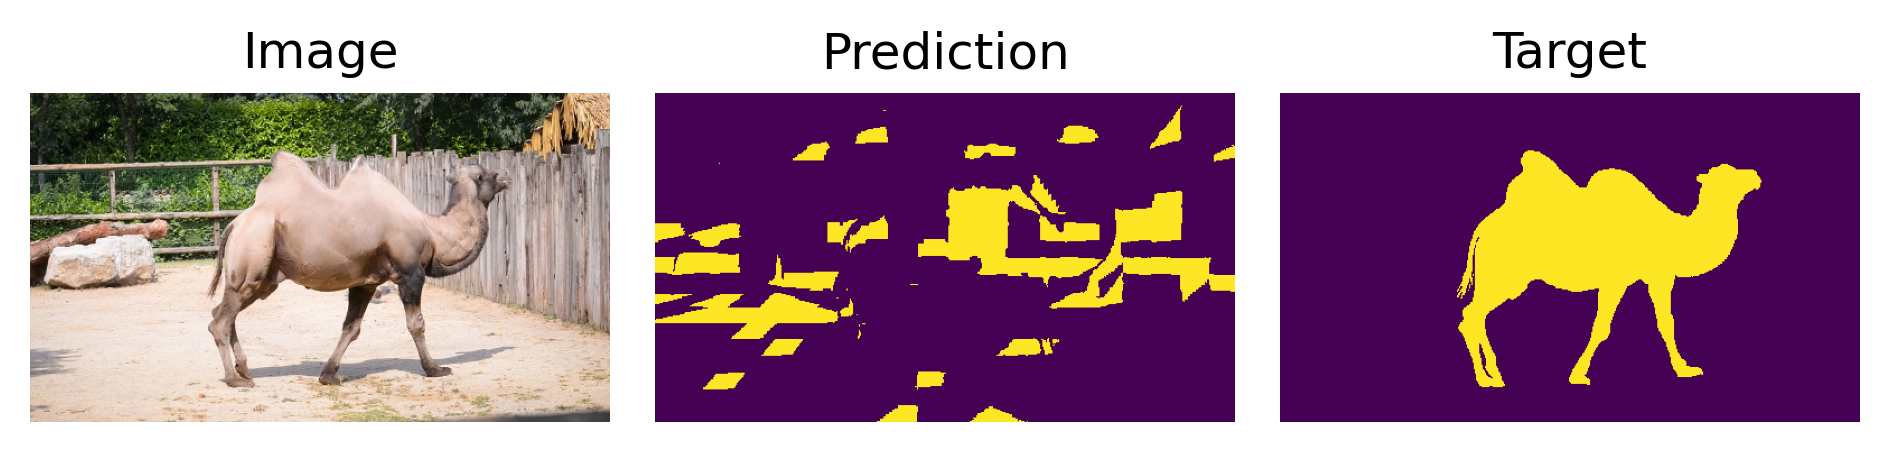

In [26]:
from argparse import Namespace
args = Namespace(dataroot='/mnt/hdd/DAVIS/DAVIS/JPEGImages/480p/camel', cpu=False)
root = Path(args.dataroot)
if torch.cuda.is_available() and not args.cpu:
    device = torch.device('cuda')
    dtype = torch.bfloat16
else:
    device = torch.device('cpu')
    dtype = torch.float32
image_fns = list(sorted(root.glob('*.jpg')))
images = [read_image(fn) for fn in image_fns]
label_fns = list(sorted(Path(str(root).replace('JPEGImages', 'Annotations')).glob('*.png')))
labels = [read_image(fn) for fn in label_fns]
rec_4d = np.load(root/'STv2'/'result.npz')
print('Loaded 4D Reconstruction from SpatialTrackerV2:')
for k,v in rec_4d.items():
    print(f'{k}: {v.shape}')
label = labels[0].to(device).float()
print('label orig', label.shape)
label = preprocess_image(label).round().to(torch.uint8).squeeze()
print('label preproc', label.shape, label.min(), label.max())
procd = process_point_cloud_data(rec_4d, width=label.size(-1), height=label.size(-2))

tracks = torch.as_tensor(rec_4d['coords']).to(device).to(dtype) # T, N, 3
points = torch.as_tensor(rec_4d['point_map']).permute(0,2,3,1).to(dtype).to(device) # T, H, W, 3
grid = torch.as_tensor(rec_4d['grid_pts']).round().long().squeeze().to(device)
print('tracks', tracks.shape, tracks.min(), tracks.max())
scene_bb = [points[...,i].max().item() - points[...,i].min().item() for i in range(points.size(-1))]
print(f'Scene Size: {scene_bb}')
print('points', points.shape, points.min(), points.max())
print('grid', grid.shape, grid.min(), grid.max())
gy, gx = grid[:,1], grid[:,0]
print('gy', gy.shape, gy.min(), gy.max())
print('gx', gx.shape, gx.min(), gx.max())

points_nn = torch.zeros(points.shape[:3], device=device, dtype=torch.long)
for b in range(points.size(0)):
    points_nn[b] = ((points[b, None, :, :, :] - tracks[b, :, None, None, :]) ** 2).sum(dim=-1).argmin(dim=0)
print('points_nn', points_nn.shape, points_nn.min(), points_nn.max())
print('points_nn distirbution:', torch.histc(points_nn, bins=10))
track_labels = label[gy, gx]
print('track_labels', track_labels.shape, track_labels.min(), track_labels.max())

point_labels = track_labels[points_nn].round().to(torch.uint8)
print('point_labels', point_labels.shape, point_labels.min(), point_labels.max())

out_dir = root/'spatrac_pred'
import shutil
shutil.rmtree(out_dir)
out_dir.mkdir(exist_ok=True)
fig, ax = plt.subplots(1,3, dpi=300, tight_layout=True)
for x in ax: x.set_axis_off()
ax[0].set_title('Image')
ax[1].set_title('Prediction')
ax[2].set_title('Target')
im1 = ax[0].imshow(preprocess_image(images[0]).permute(1,2,0))
im2 = ax[1].imshow(point_labels[0].cpu())
im3 = ax[2].imshow(preprocess_image(labels[0]).round().to(torch.uint8).squeeze())
#for i, im, pred, lab in zip(count(), images, point_labels, labels):
#    im1.set_data(preprocess_image(im).permute(1,2,0))
#    im2.set_data(pred.cpu())
#    im3.set_data(preprocess_image(lab).round().to(torch.uint8).squeeze())
#    fig.savefig(out_dir/f'{i:05d}.png')
#    plt.close(fig)


In [42]:
htracks = F.pad(tracks, (0,1), value=1.0)
hpoints = F.pad(points, (0,1), value=1.0)
track0 = htracks[0]
track10 = htracks[50]
pts0 = hpoints[0].reshape(-1,4)
pts10 = hpoints[50].reshape(-1,4)

In [28]:
intrinsic[0], extrinsic[10]

(array([[1.18077600e+03, 0.00000000e+00, 2.59000000e+02, 0.00000000e+00],
        [0.00000000e+00, 1.17279785e+03, 1.47000000e+02, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[ 9.9937344e-01, -3.5636482e-04, -3.5392929e-02,  2.0129520e-03],
        [ 5.8453507e-04,  9.9997908e-01,  6.4366381e-03, -2.4175449e-04],
        [ 3.5389893e-02, -6.4532934e-03,  9.9935275e-01, -1.6947073e-03],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
       dtype=float32))

In [29]:
tracks.shape

torch.Size([90, 400, 3])

In [30]:
step = ((tracks[0] - tracks[30])**2)[:,:2].sum(dim=-1).sqrt()
step.min(), step.max()

(tensor(0., device='cuda:0', dtype=torch.bfloat16),
 tensor(0.0742, device='cuda:0', dtype=torch.bfloat16))

In [45]:
intrinsic = np.repeat(np.eye(4)[None], points.size(0), axis=0)
intrinsic[:, :3, :3], extrinsic = rec_4d['intrinsics'], rec_4d['extrinsics']

in0 = (torch.as_tensor(intrinsic[0]).to(device).to(dtype) @ track0.T).T.cpu().float().numpy()[...,:3]
in10 = (torch.as_tensor(intrinsic[0]).to(device).to(dtype) @ track10.T).T.cpu().float().numpy()[...,:3]
pt0 = (torch.as_tensor(intrinsic[0]).to(device).to(dtype) @ pts0.T).T.cpu().float().numpy()[...,:3]
pt10 = (torch.as_tensor(intrinsic[0]).to(device).to(dtype) @ pts10.T).T.cpu().float().numpy()[...,:3]

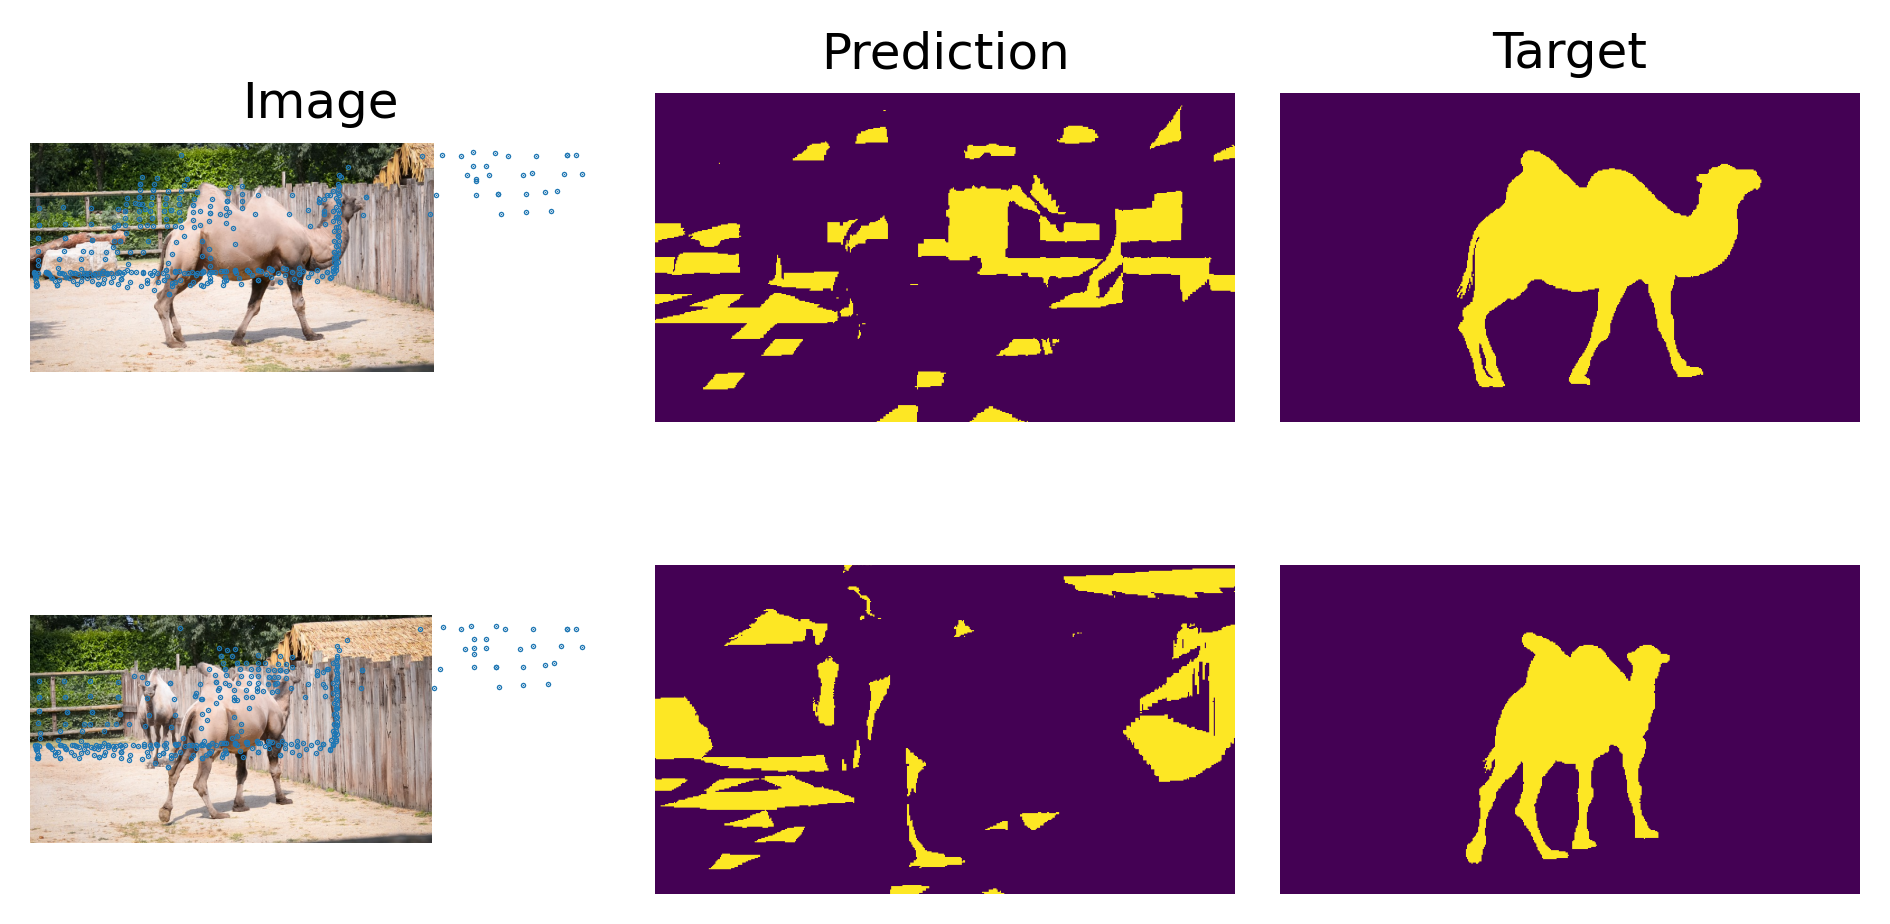

In [46]:
fig, ax = plt.subplots(2,3, dpi=300, tight_layout=True)
for x in ax.flatten(): x.set_axis_off()
ax[0,0].set_title('Image')
ax[0,1].set_title('Prediction')
ax[0,2].set_title('Target')
ax[0,0].imshow(preprocess_image(images[0]).permute(1,2,0))
ax[0,1].imshow(point_labels[0].cpu())
ax[0,2].imshow(preprocess_image(labels[0]).round().to(torch.uint8).squeeze())
ax[0,0].scatter(in0[:, 0], in0[:, 1], s=.1)
ax[1,0].imshow(preprocess_image(images[50]).permute(1,2,0))
ax[1,1].imshow(point_labels[50].cpu())
ax[1,2].imshow(preprocess_image(labels[50]).round().to(torch.uint8).squeeze())
ax[1,0].scatter(in10[:, 0], in10[:, 1], s=.1)

In [47]:
in0.min(0), in0.max(0)

(array([ 4.25     , 11.5      ,  0.2734375], dtype=float32),
 array([708.       , 194.       ,   1.7421875], dtype=float32))

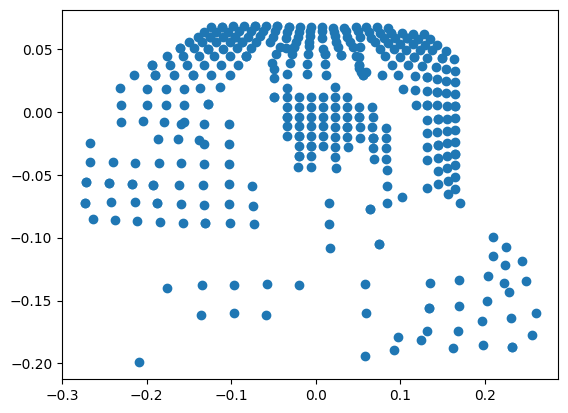

In [48]:
plt.scatter(tracks[0,:,0].cpu().float().numpy(), tracks[0,:,1].cpu().float().numpy())

In [49]:
tracks[0].min(dim=0).values, tracks[0].max(dim=0).values, grid.min(0).values, grid.max(0).values, in0.min(0), in0.max(0)

(tensor([-0.2734, -0.1992,  0.2734], device='cuda:0', dtype=torch.bfloat16),
 tensor([0.2598, 0.0679, 1.7422], device='cuda:0', dtype=torch.bfloat16),
 tensor([8, 8], device='cuda:0'),
 tensor([510, 286], device='cuda:0'),
 array([ 4.25     , 11.5      ,  0.2734375], dtype=float32),
 array([708.       , 194.       ,   1.7421875], dtype=float32))

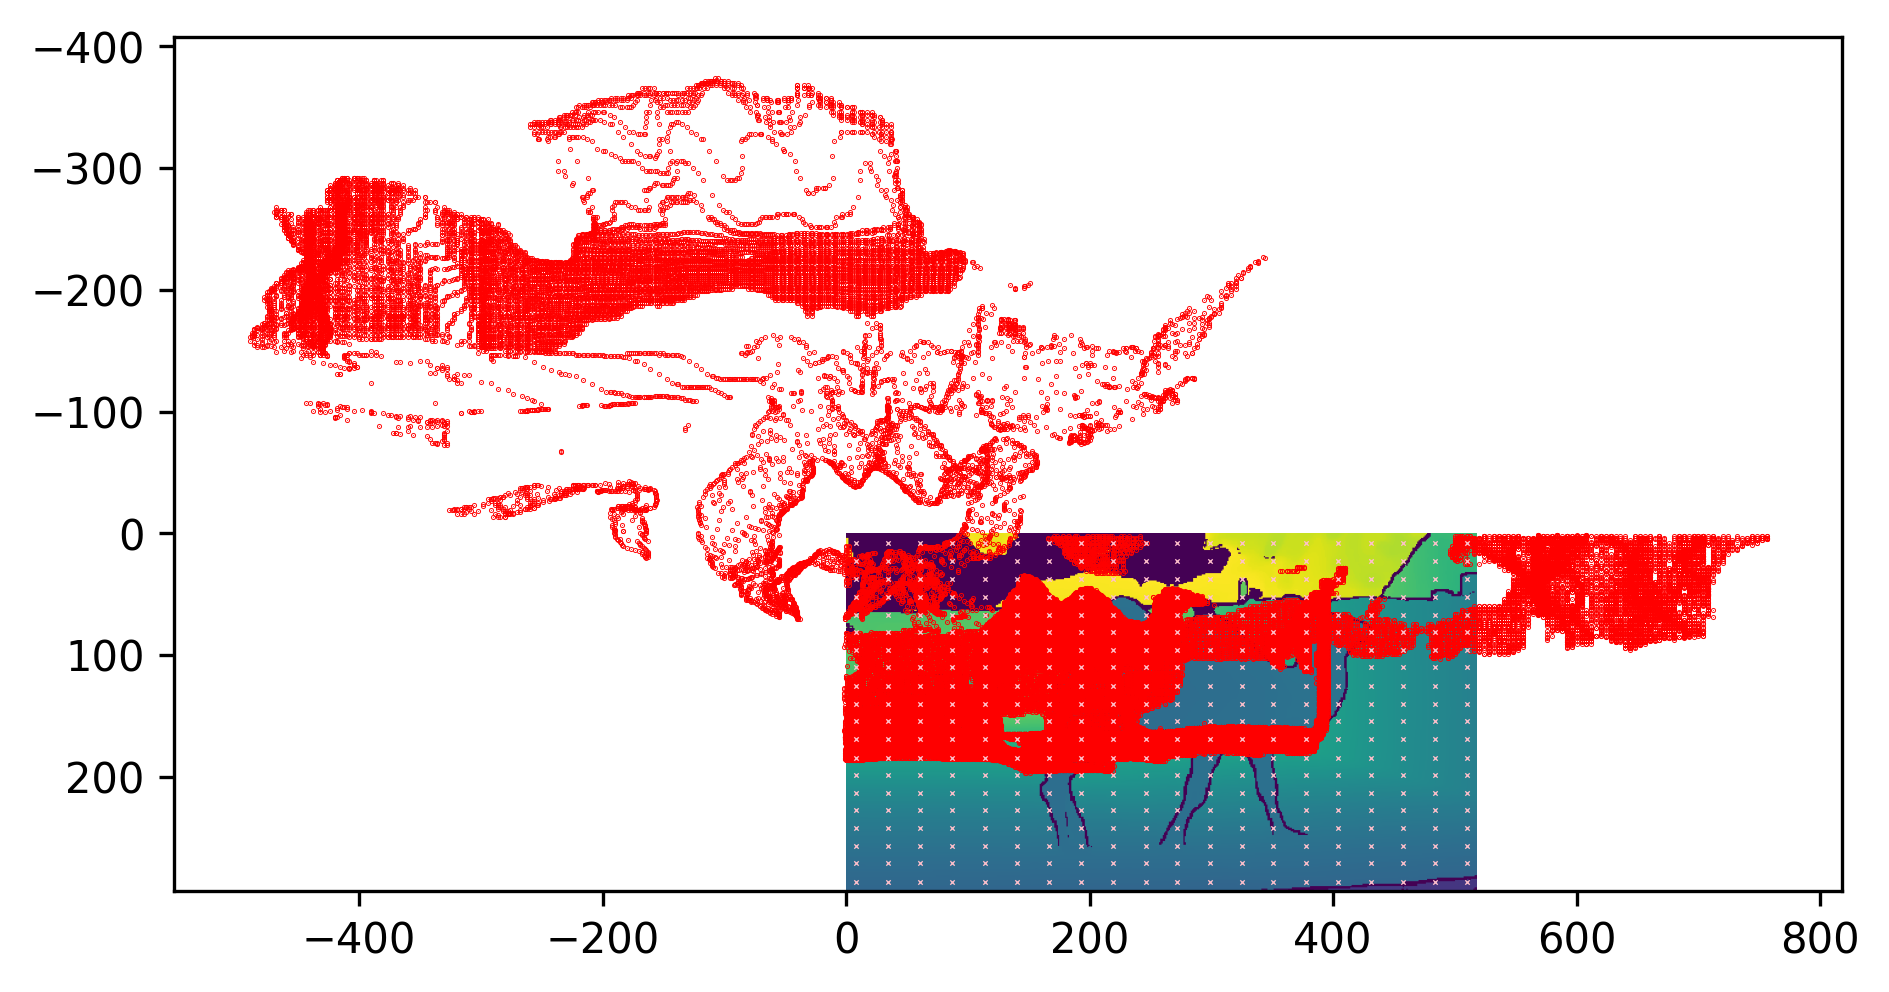

In [50]:
fig, ax = plt.subplots(1,1, tight_layout=True, dpi=300)
ax.imshow(points[0, :, :, 2].cpu().float().numpy(),)
ax.scatter(pt0[:,0], pt0[:,1], s=0.05, c='red')
ax.scatter(grid[:,0].cpu(), grid[:,1].cpu(), s=0.05, c='pink', marker='x')

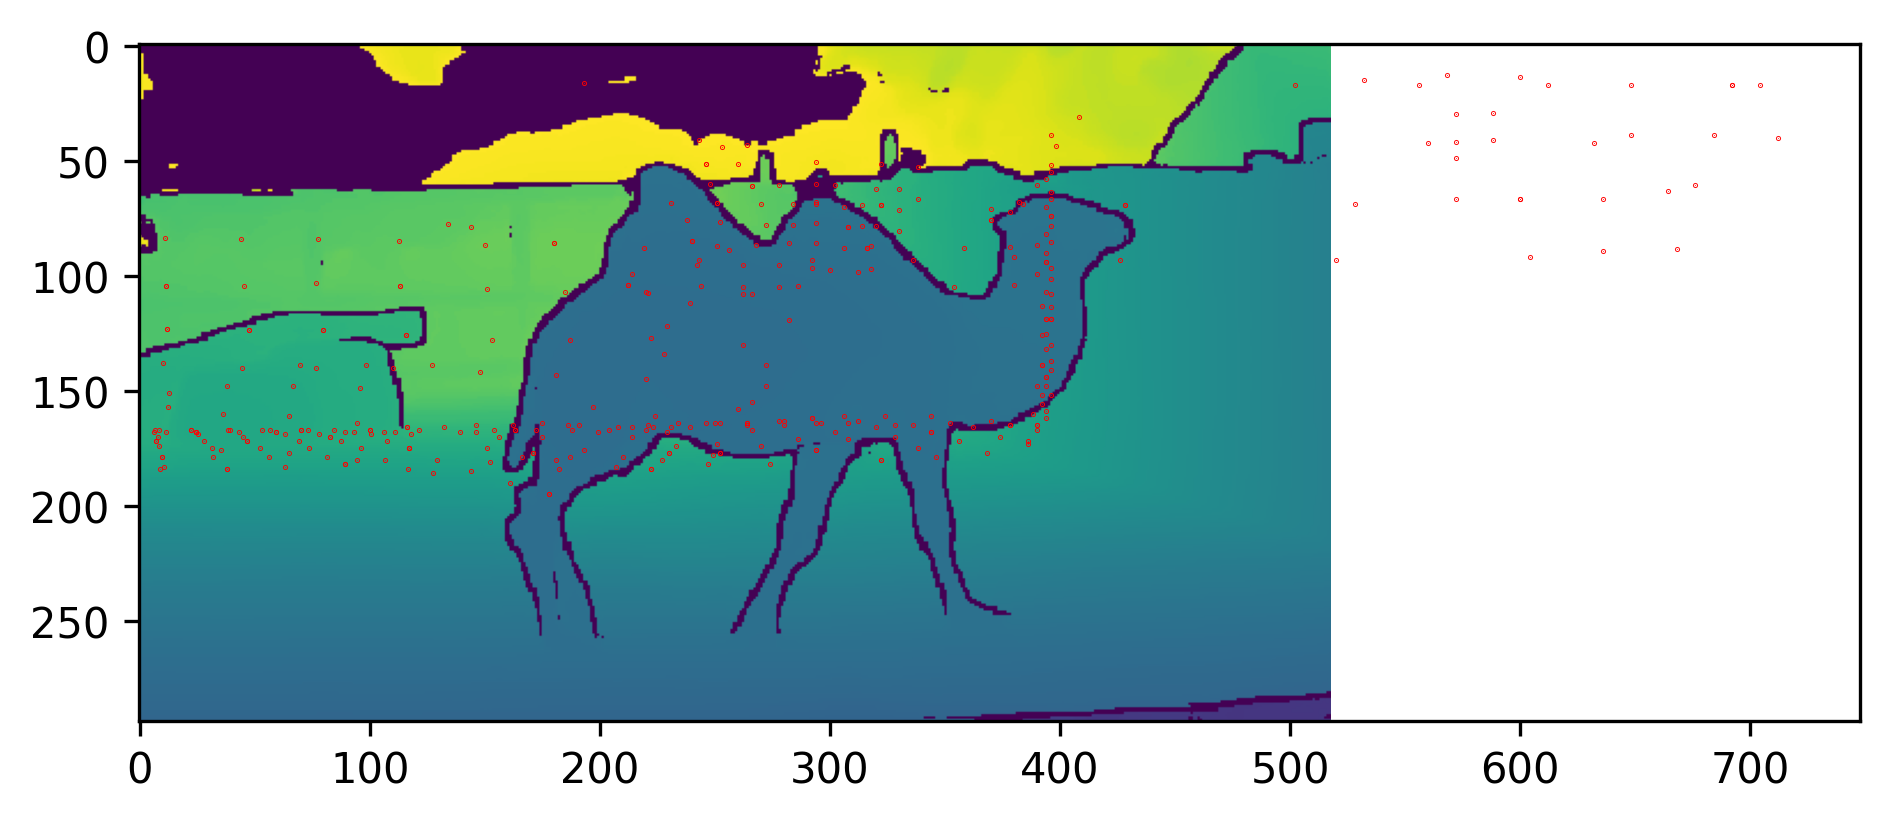

In [37]:
fig, ax = plt.subplots(1,1, tight_layout=True, dpi=300)
ax.imshow(points[0, :, :, 2].cpu().float().numpy(),)
ax.scatter(in10[:,0], in10[:,1], s=0.05, c='red')

In [16]:
1+1

2